In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from afrc import AnalyticalFRC
from sparrow import Protein
from shephard import interfaces, apis
a
from scipy.signal import savgol_filter
import metapredict as meta
from sparrow.data.amino_acids import VALID_AMINO_ACIDS
import pandas as pd

In [9]:
# read in SAXS data
data = pd.read_csv('data/saxs_data.csv')

In [10]:
# read in the sequences
seqs = {}
for index, row in data.iterrows():
    
    n = row['Name']
    s = row['seq']
    
    seqs[n] = s

In [4]:
# read in predictsions made using the IDPGan notebook online
IDPgan = pd.read_csv('data/idpgan_results.csv')

# read in predictsion made using the CALVADOS2 predictions online
CALVADOS2 = pd.read_csv('data/CALVADOS2_SAXS_Sequences.csv')

### Predict / extract IDR dimensions from ALBATROSS and pre-computed values
For ALBATROSS predictions this takes ~5 seconds for 137 sequences, although if done in batch this would be substantially faster.


In [8]:
%%time

LAMMPS_rg = []
SAXS_rg = []
rg_prediction = {}
name2idx = {}
idx2name= {}
rg_prediction['ALBATROSS'] = []
rg_prediction['Zheng'] = []
rg_prediction['IDPGan'] = []
rg_prediction['AFRC'] = []
rg_prediction['CALVADOS2'] = []
for index, row in data.iterrows():
    
    prot_name = row['Name']
    
    name2idx[prot_name] = index
    idx2name[index] = prot_name
    LAMMPS_rg.append(row['LAMMPS_Rg_NO_ALIG'])
    SAXS_rg.append(row['Experimental_Rg'])
    
    # predict with ALBATROSS
    rg_prediction['ALBATROSS'].append(Protein(row['seq']).predictor.radius_of_gyration(use_scaled=True))
    
    # preddict using the SHD/SCD-based predictor of Zheng et al
    rg_prediction['Zheng'].append(Protein(row['seq']).polymeric.empirical_radius_of_gyration())
    
    # excise out IDPGan predictsion
    x = IDPgan.loc[IDPgan['Protein'] == prot_name, ' Average_Rg']
    rg_prediction['IDPGan'].append(float(x))
    
    # exise out CALVADOS2 predictions and convert to Å
    x = 10*CALVADOS2.loc[CALVADOS2['Name'] == f"{prot_name}_IDRLab", '<Rg> (nm)']
    rg_prediction['CALVADOS2'].append(float(x))
    
    # calculate expected Rg from AFRC. We emphasize this is NOT a prediction of expected dimensions, but 
    # the expected dimensions IF this chain were to behave as a flexible Gaussian chain.
    rg_prediction['AFRC'].append(Protein(row['seq']).polymeric.get_mean_afrc_radius_of_gyration())
    
    
    


<timed exec>:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
<timed exec>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


CPU times: user 4.65 s, sys: 62 ms, total: 4.71 s
Wall time: 4.72 s


In [6]:
def calc_rmse(d1,d2):    
    """
    Function that given two lists or vectors, calculates the root-mean-square error (RMSE)
    between the two input datasets. Assumes both are the same length
    
    Parameters
    -------------
    d1 : list/vector/np.ndarray
        Dataset 1

    d2 : list/vector/np.ndarray
        Dataset 2
        
    Returns
    -------------
    float
        Returns a float which is the RMSE between the two datasets
        

    """
    
    return np.sqrt(np.mean(np.power(np.array(d1) - np.array(d2),2)))


## Save all data plotted in Fig. S8
The cell below generates a nicely-formatted CSV file that contains all the comparison data plotted in Fig. S8. This table provided as table S6 in the Lotthammer/Ginell/Griffth manuscriot. Note that references for all sequences can be found in the supplementary information for [Alston & Ginell et al. J.Phys. Chem. B](https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.3c01619) (Table S4)

In [38]:
with open('all_comparison_data.csv','w') as fh:

    fh.write('index, name, SAXS Rg (A), ALBATROSS Rg (A) [pred], IDPGan Rg (A) [pred], Zheng Rg (A), CALVADOS2 Rg (A) [sim], Mpipi-GG (A) [sim], AFRC Rg (A) [polymer model], sequence\n')

    for k in name2idx:
        local_seq = seqs[k]
        idx = name2idx[k]
                
        outstring = str(idx) + ", "
        outstring = outstring + f"{k}, "
        outstring = outstring + f"{SAXS_rg[idx]}, "
        outstring = outstring + f"{round(rg_prediction['ALBATROSS'][idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['IDPGan'][idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['Zheng'][idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['CALVADOS2'][idx],2)}, "
        outstring = outstring + f"{round(LAMMPS_rg[idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['AFRC'][idx],2)}, "
        outstring = outstring + local_seq
    
        outstring = outstring +"\n"

        fh.write(outstring)


## SCD/SHD prediction vs. SAXS
Note that several points fall outside of the range shown here, hence the very low r^2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


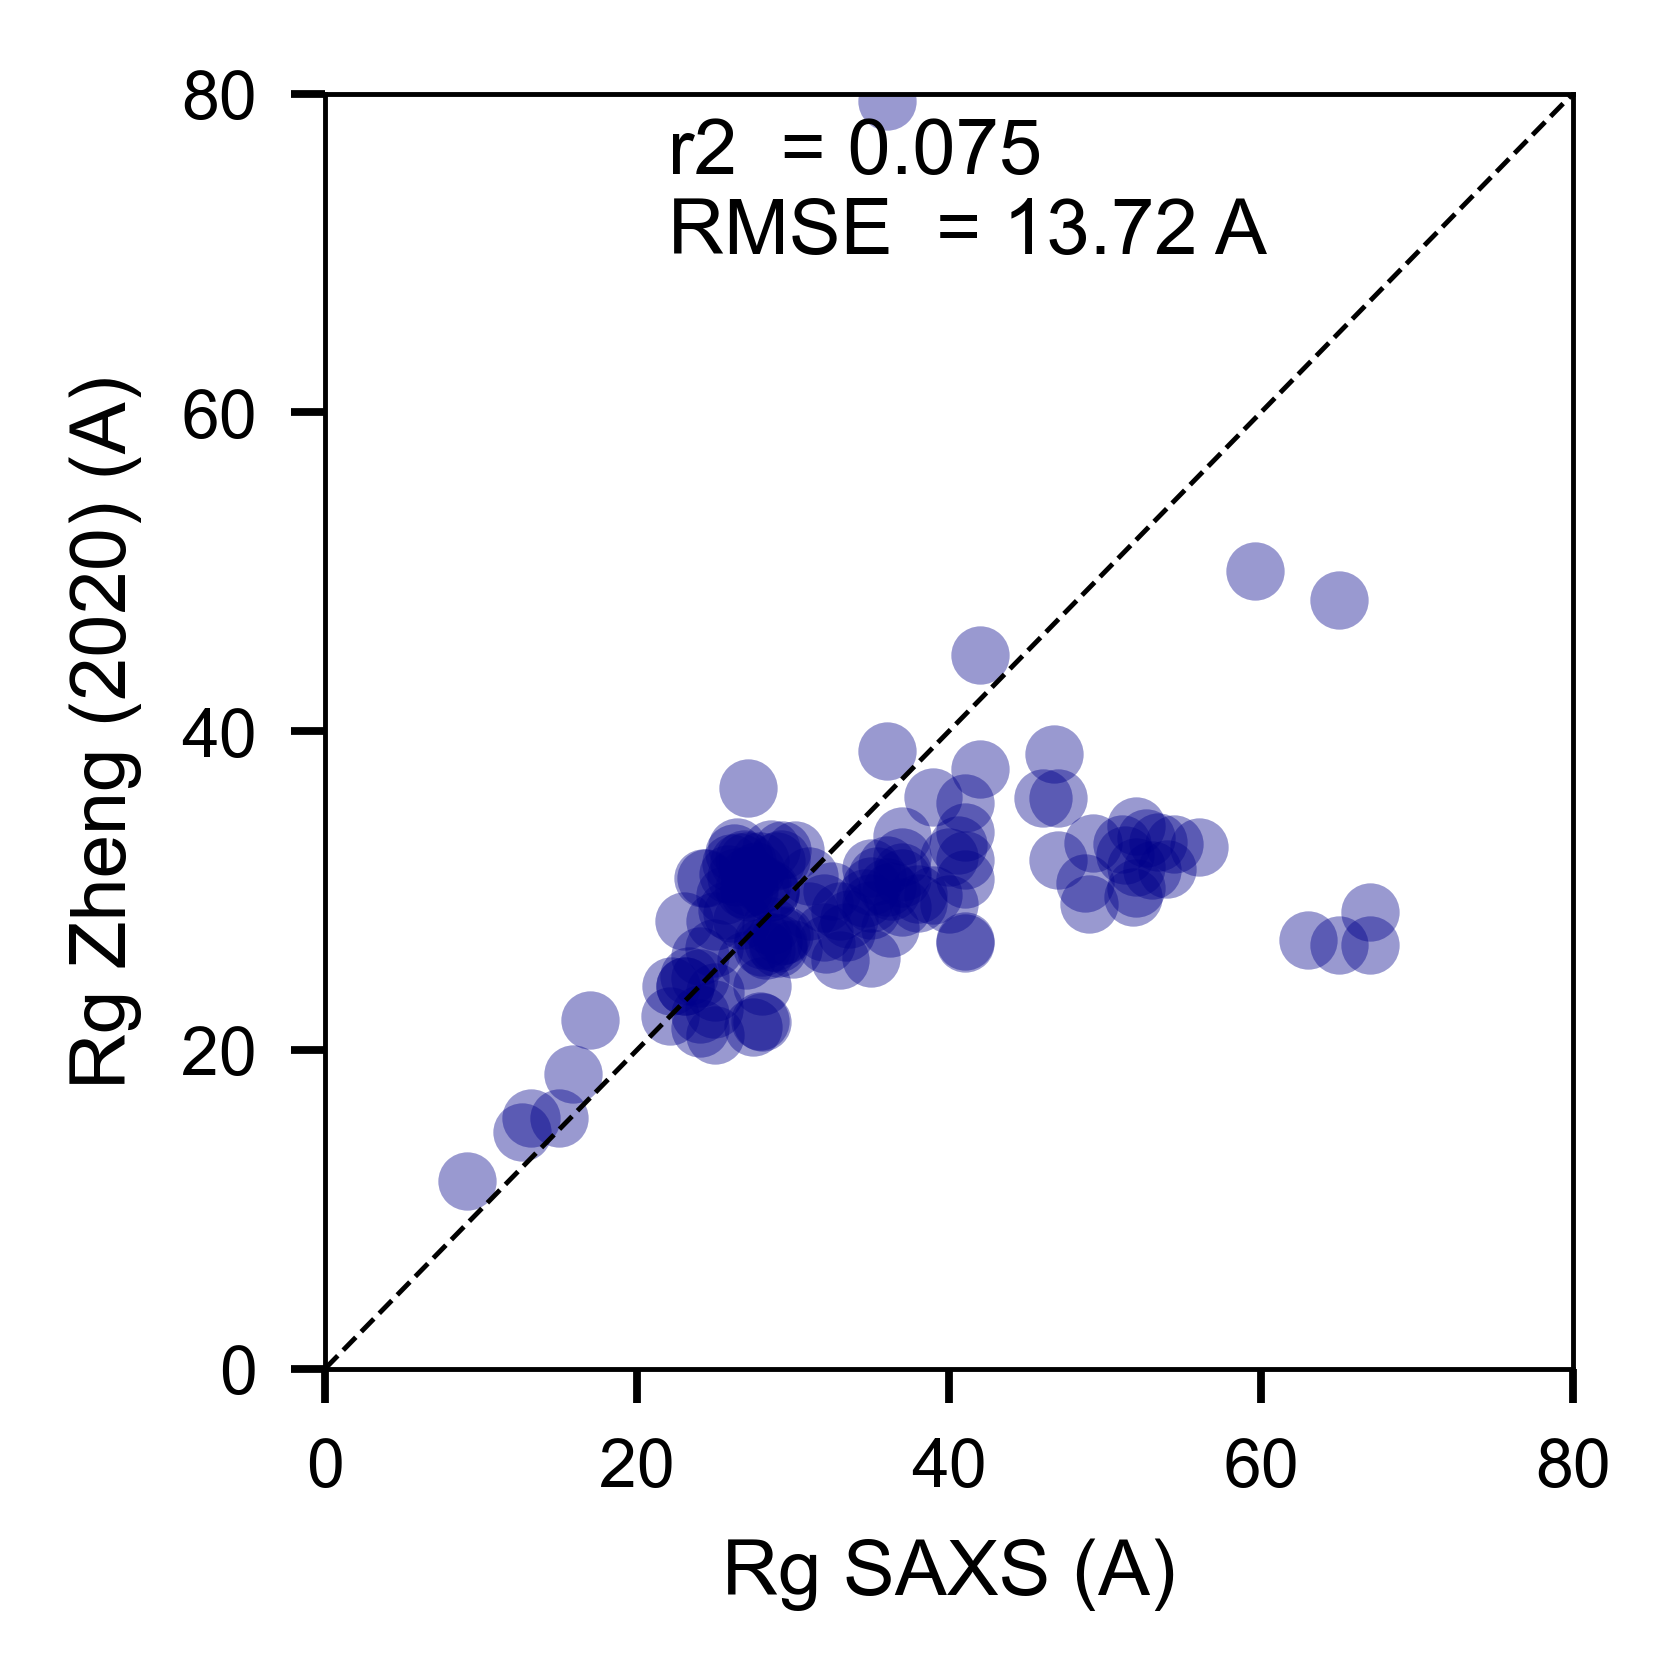

In [74]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg.copy()
d2 = rg_prediction['Zheng'].copy()

plt.plot(d1, d2, '.', color='darkblue', ms=12, mew=0, alpha=0.4, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg Zheng (2020) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_Zheng.pdf')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


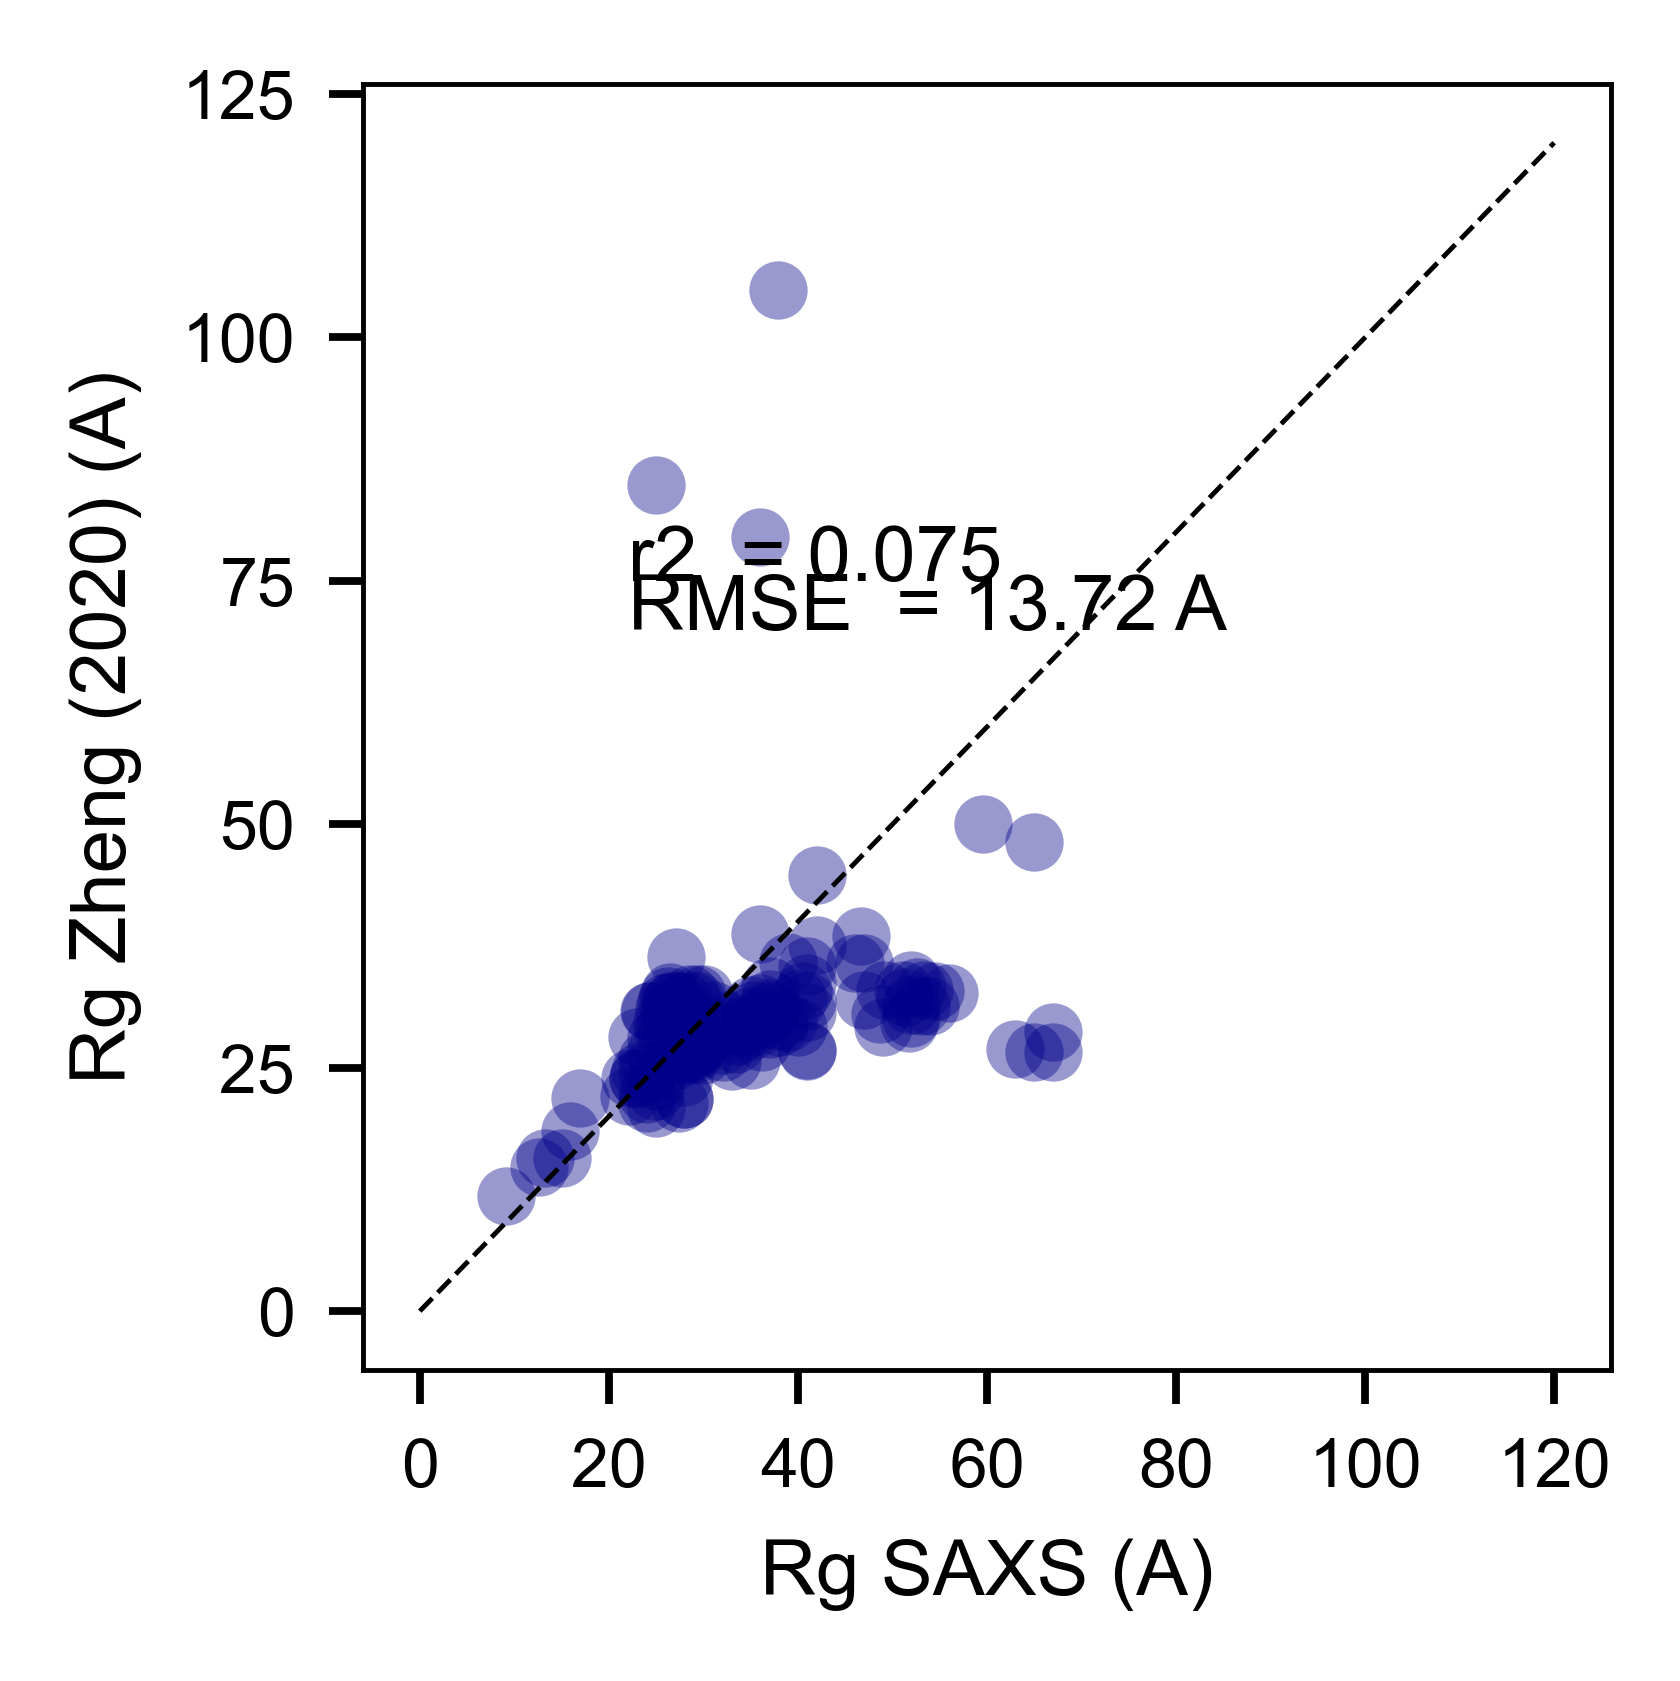

In [75]:
#
# Same as above, but without the ylim/xlim
#

figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg.copy()
d2 = rg_prediction['Zheng'].copy()

plt.plot(d1, d2, '.', color='darkblue', ms=12, mew=0, alpha=0.4, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg Zheng (2020) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
#plt.ylim([0,80])
#plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_Zheng_no_lim.pdf')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


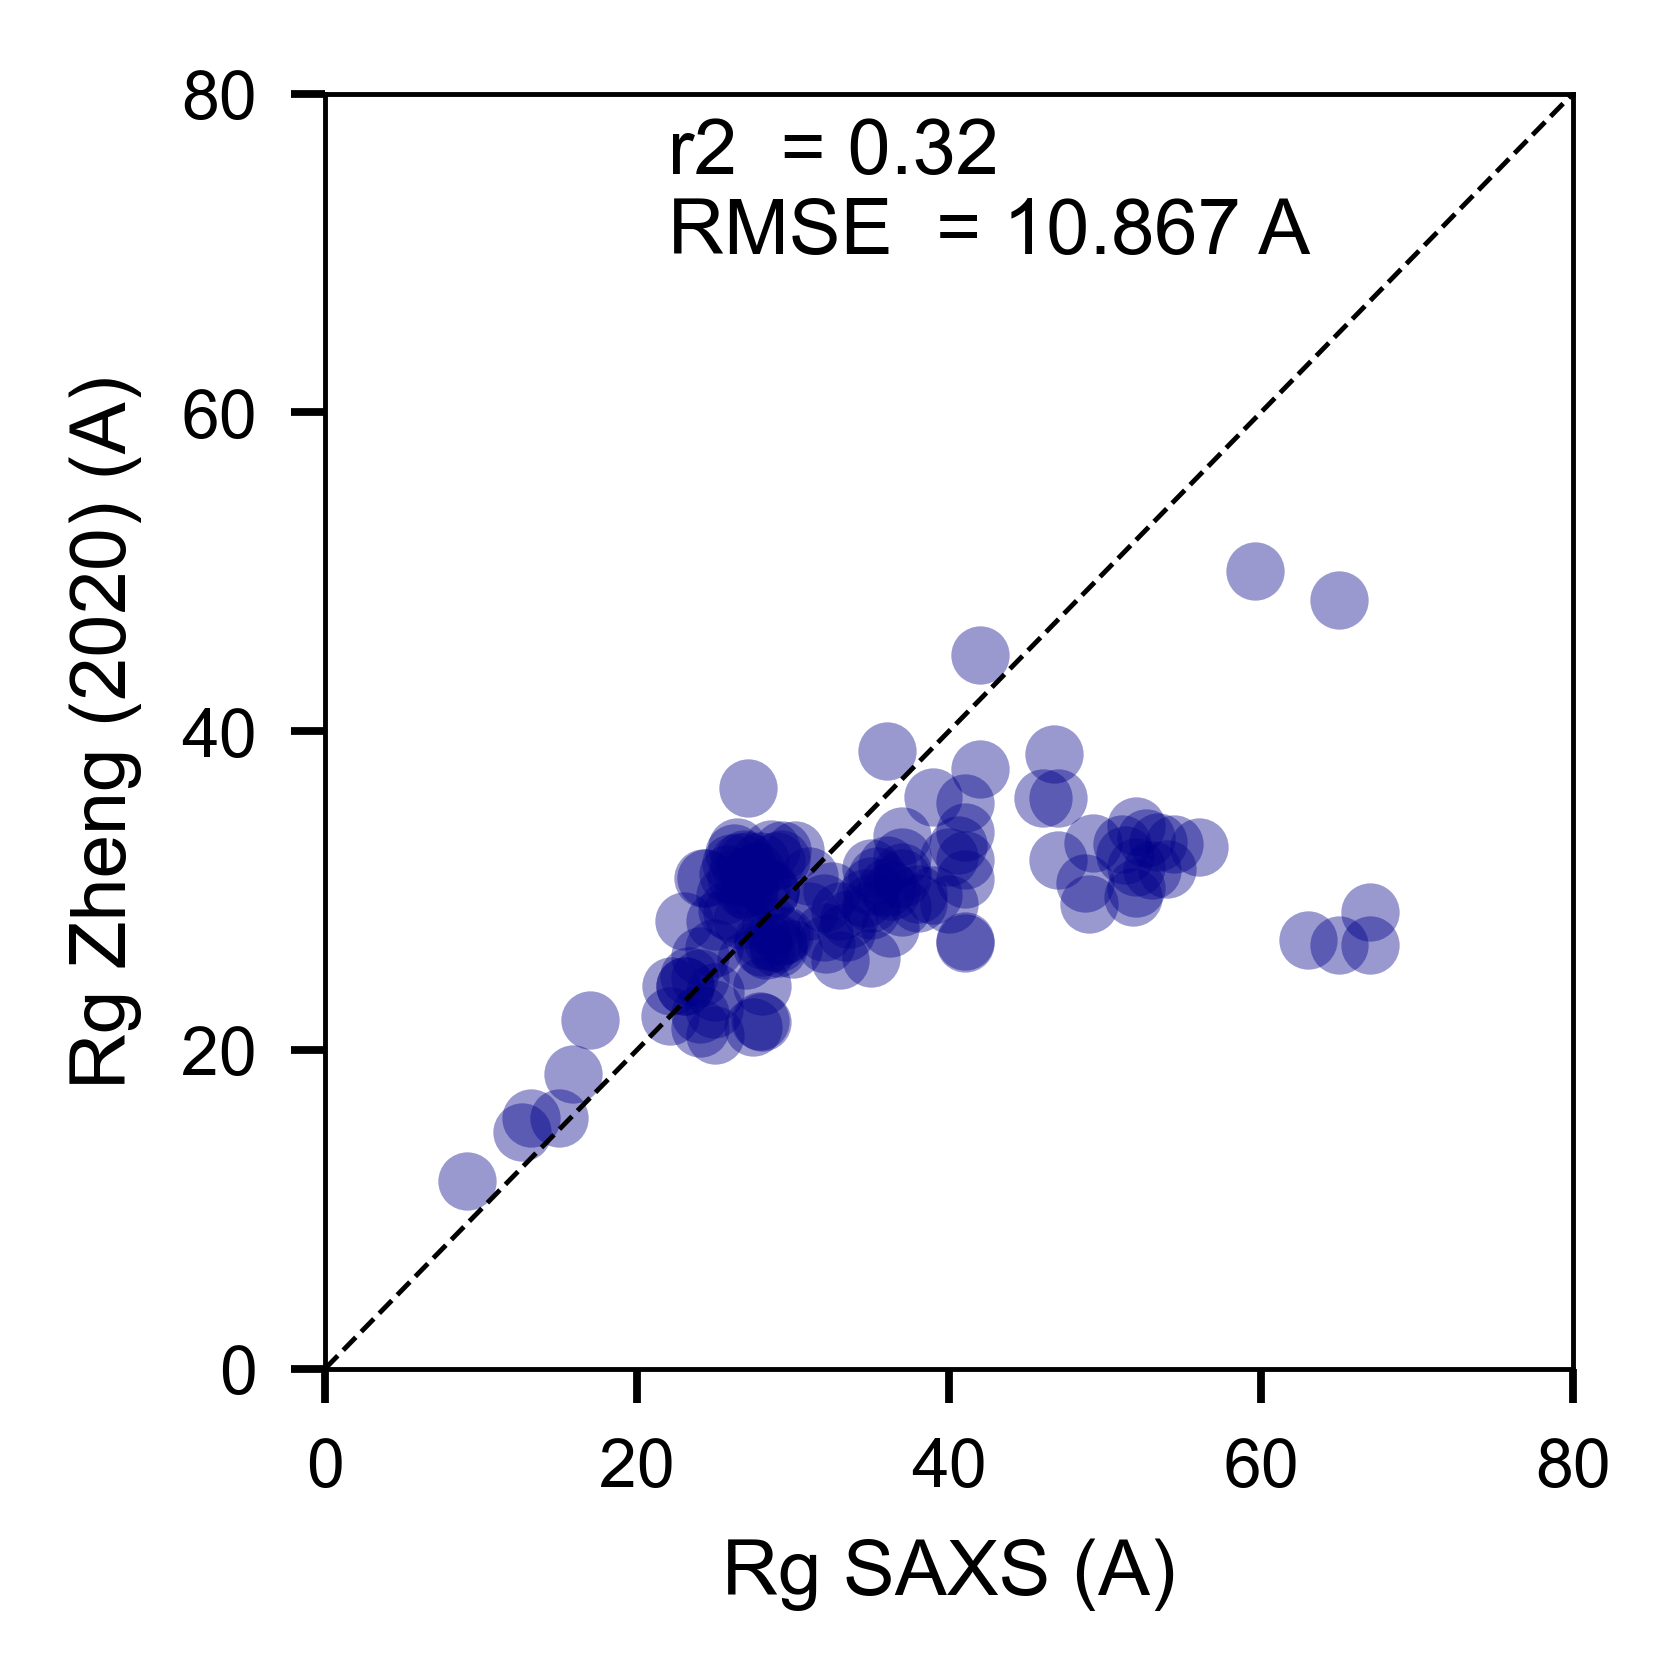

In [71]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg.copy()
d2 = rg_prediction['Zheng'].copy()

# manually remove outliers

# ProtAlpha
d1.pop(69)
d2.pop(69)

#H1_CTD
d1.pop(37)
d2.pop(37)

# Fez1
d1.pop(34)
d2.pop(34)


plt.plot(d1, d2, '.', color='darkblue', ms=12, mew=0, alpha=0.4, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg Zheng (2020) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_Zheng_without_outliers.pdf')


### IDPGAN vs. SAXS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


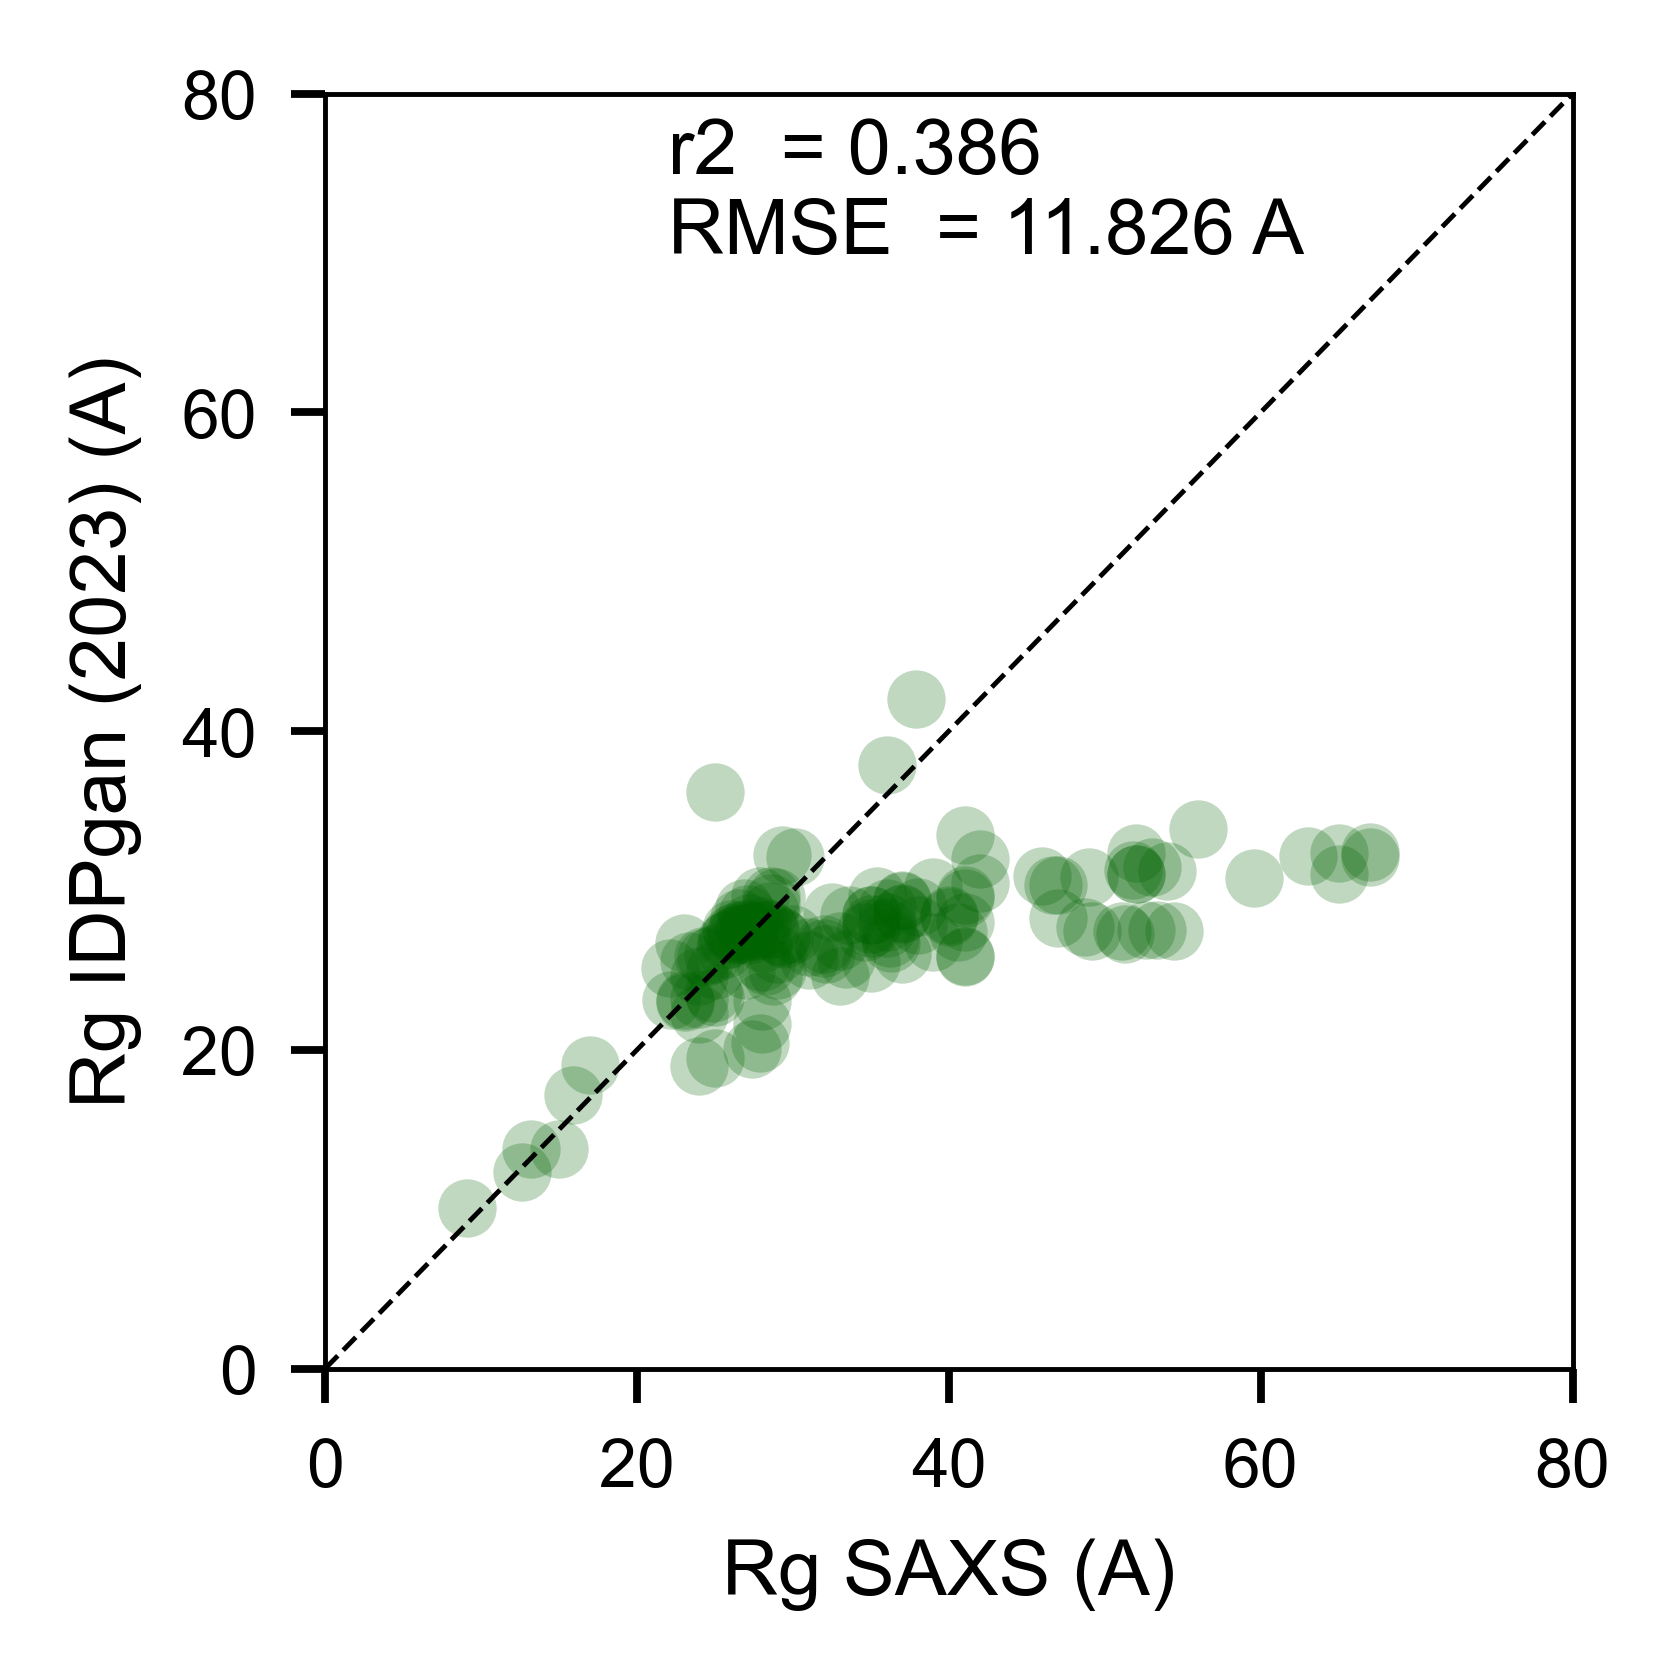

In [24]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = rg_prediction['IDPGan']



plt.plot(d1, d2, '.', color='darkgreen', ms=12, mew=0, alpha=0.25, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg IDPgan (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_IDPGan.pdf')


## AFRC vs. SAXS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


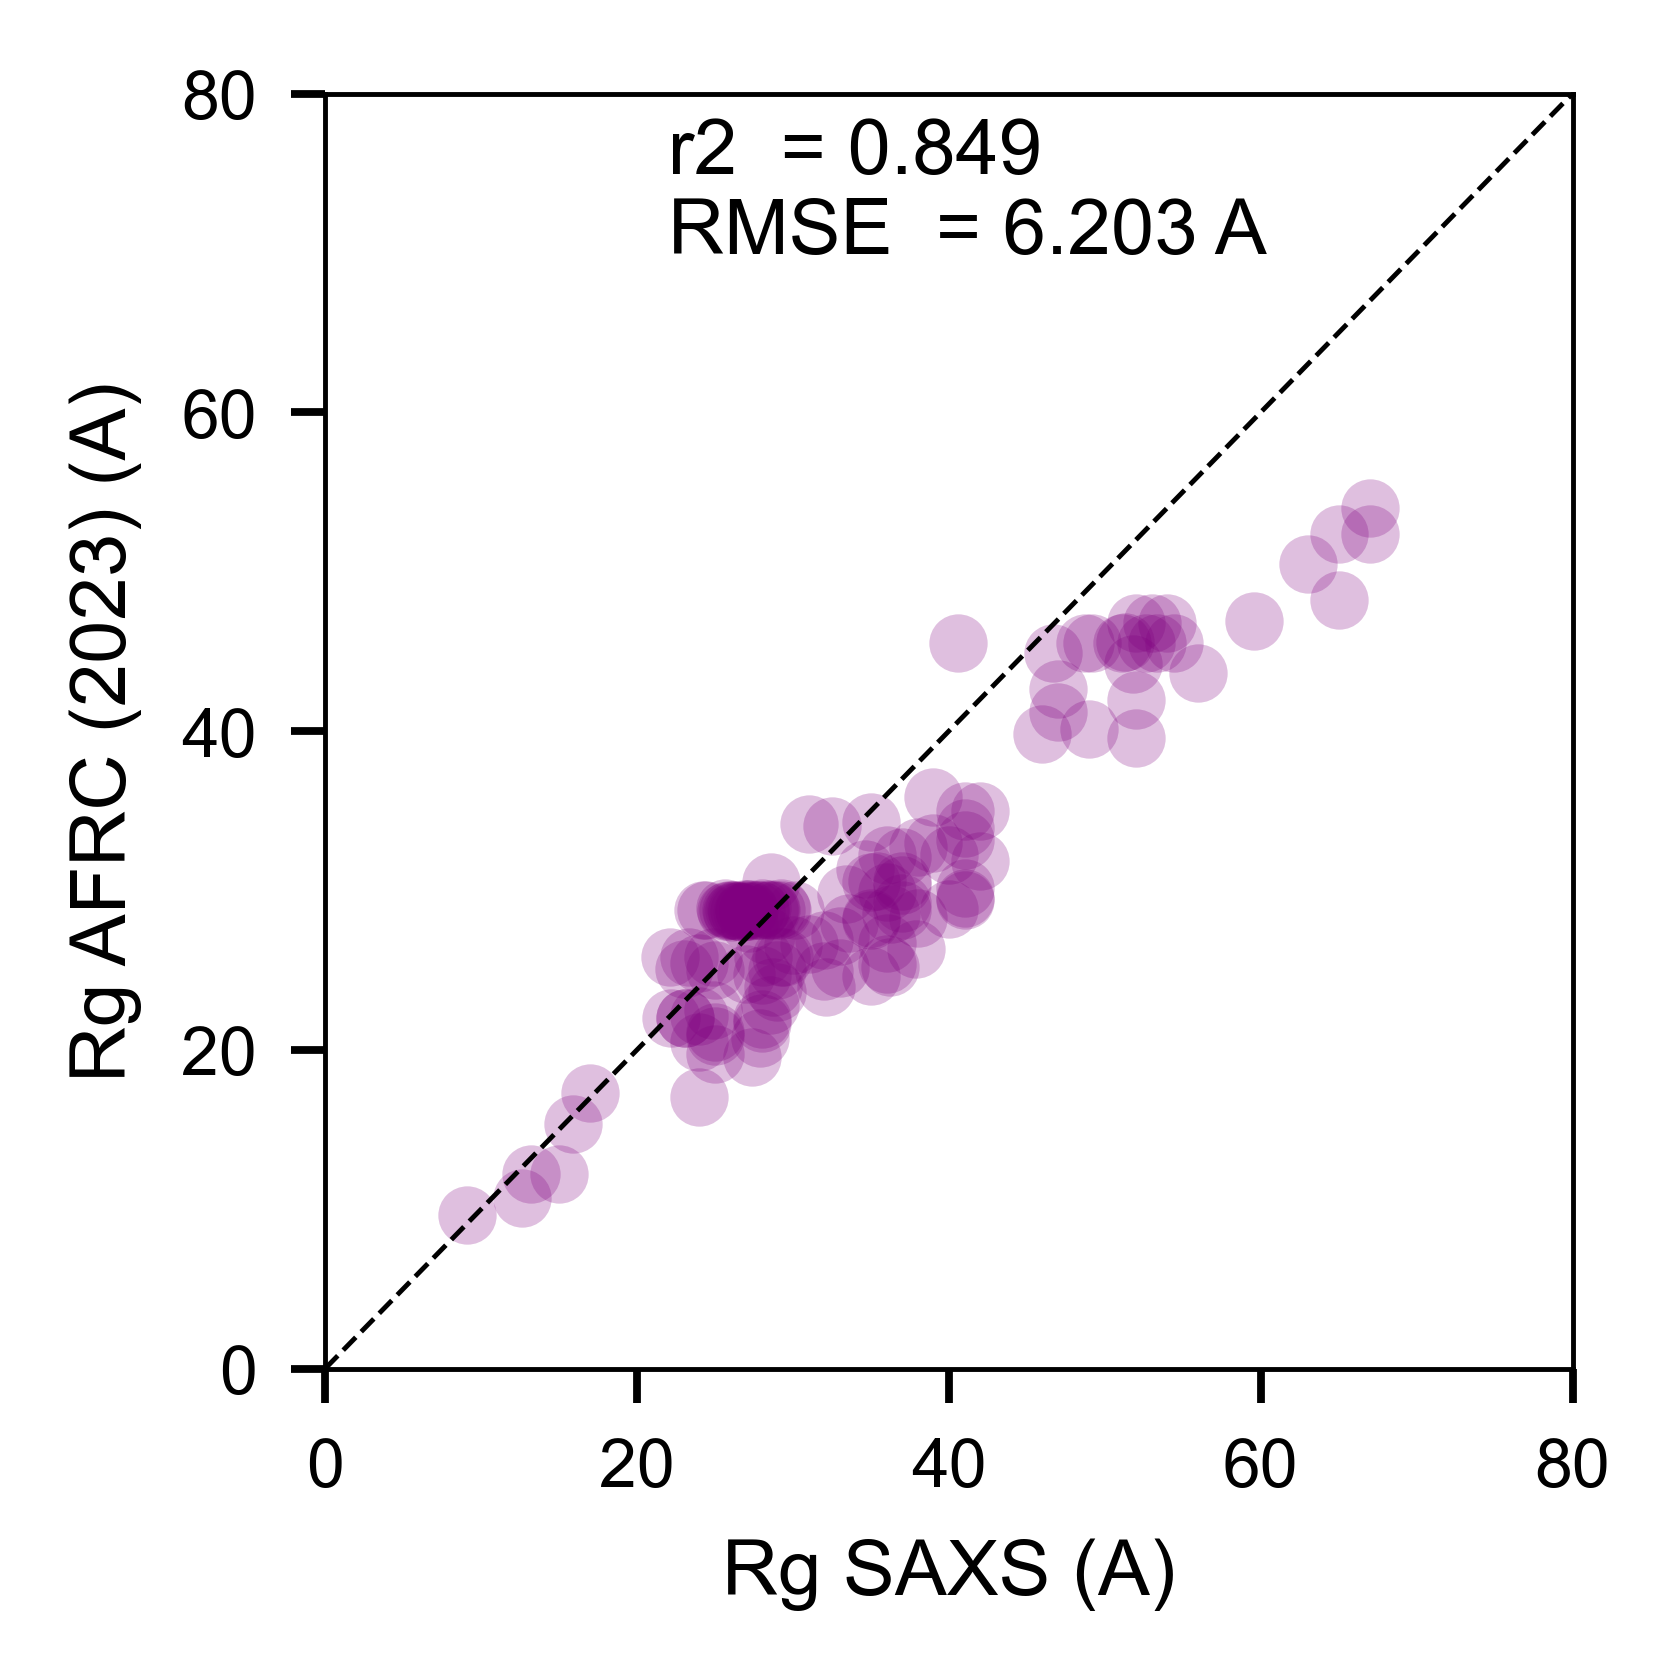

In [26]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = rg_prediction['AFRC']

plt.plot(d1, d2, '.', color='purple', ms=12, mew=0, alpha=0.25, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg AFRC (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])

plt.tight_layout()
plt.savefig('rg_SAXS_AFRC.pdf')


In [34]:
## ALBATROSS vs. SAXS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


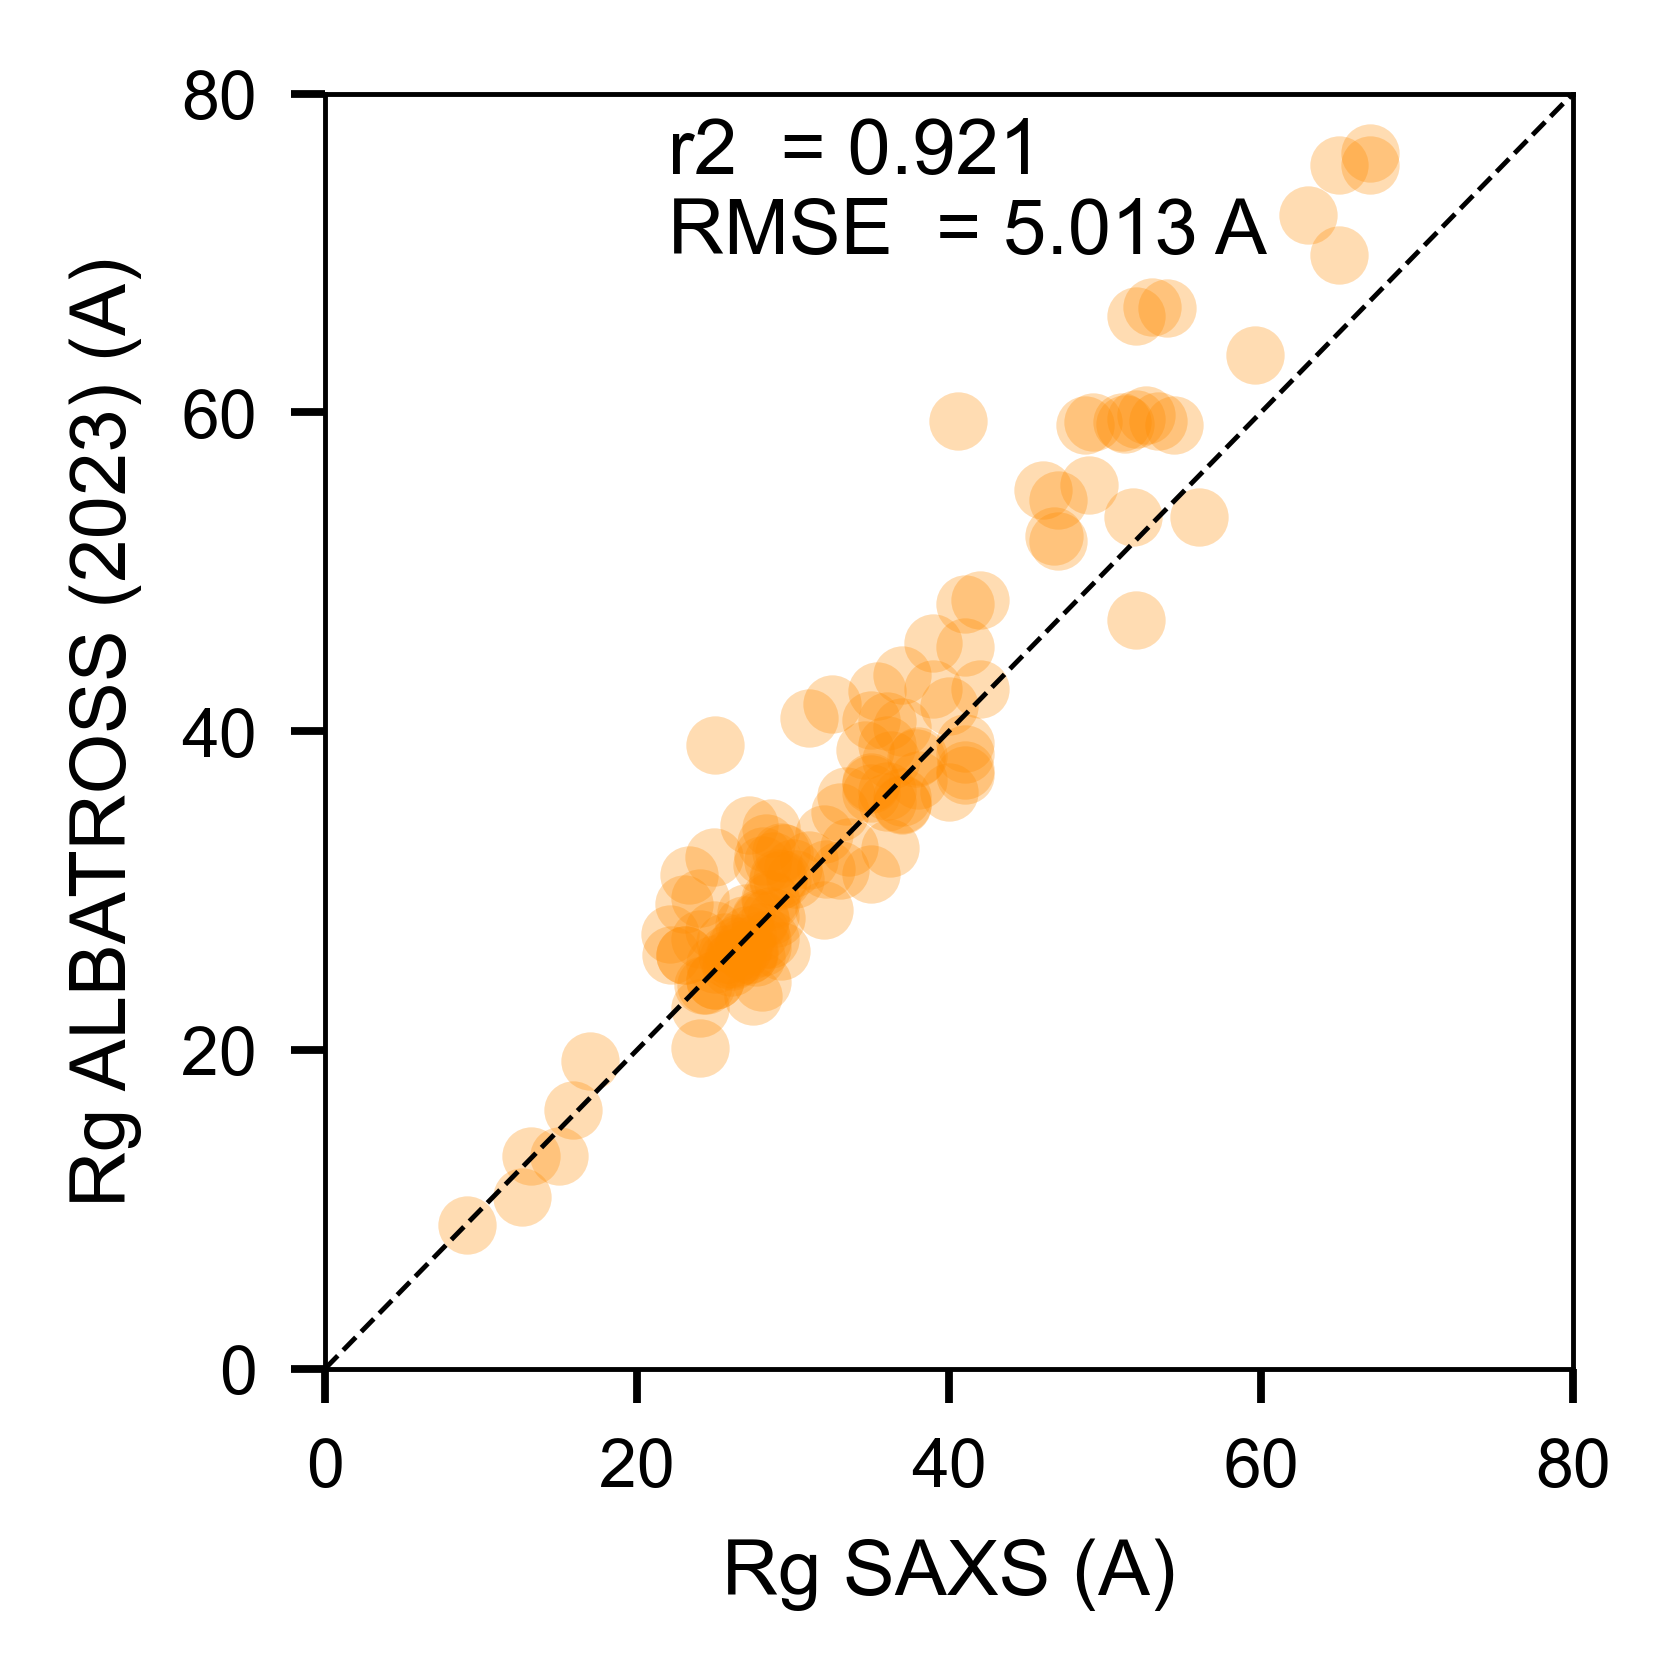

In [9]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = np.array(rg_prediction['ALBATROSS'])

plt.plot(d1, d2, '.', color='darkorange', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])




plt.tight_layout()
plt.savefig('rg_SAXS_ALBATROSS2.pdf')


## CALVADOS2 vs. SAXS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


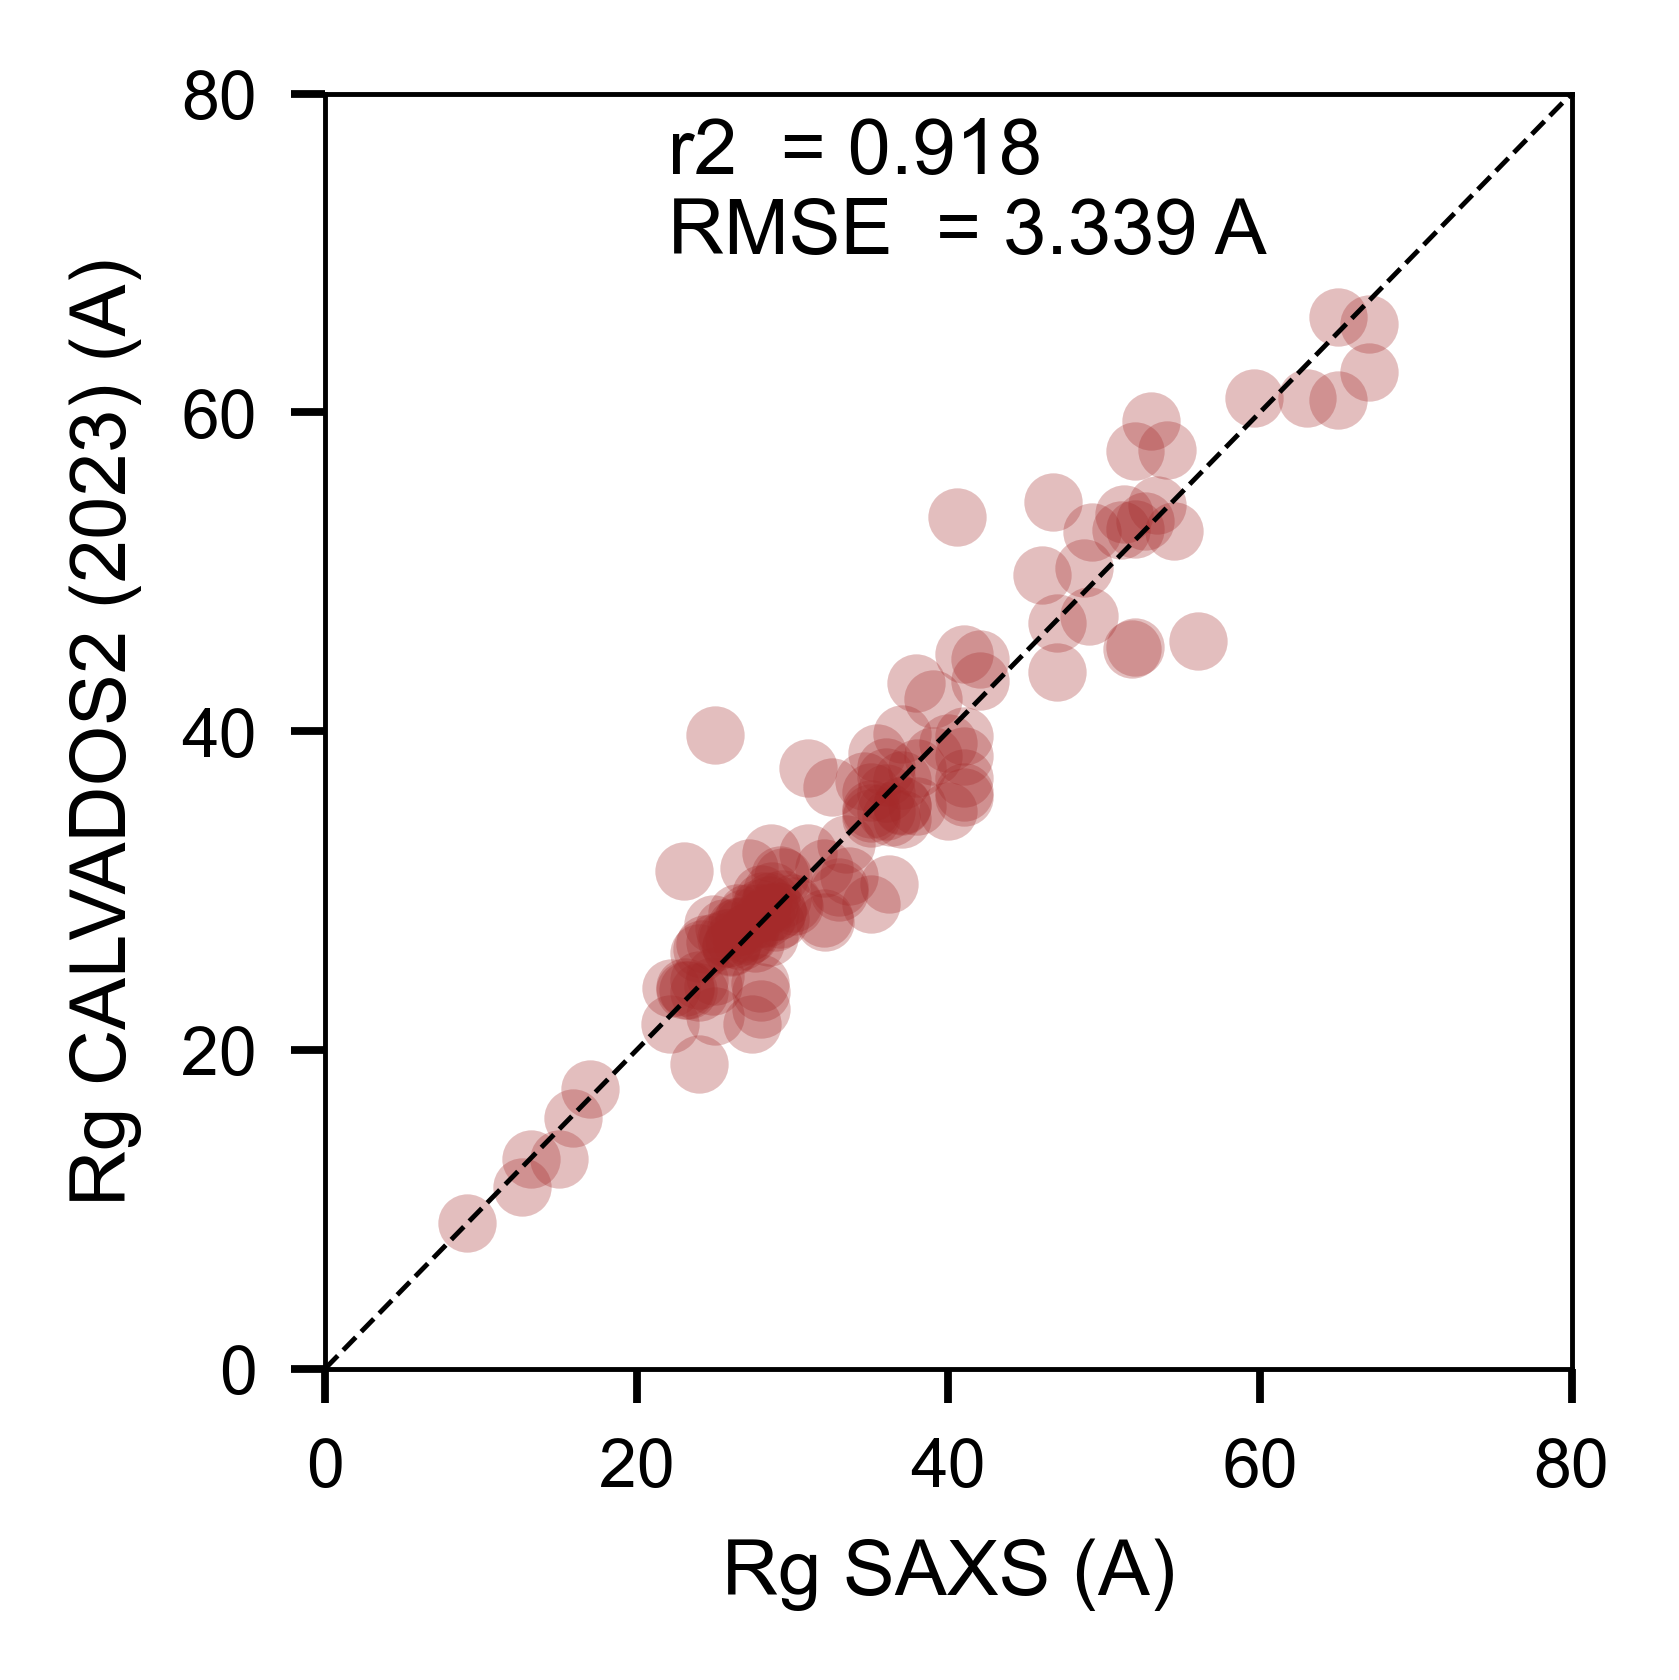

In [29]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = rg_prediction['CALVADOS2']


plt.plot(d1, d2, '.', color='brown', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg CALVADOS2 (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_CALVADOS2.pdf')


## ALBATROSS vs. Mpipi-GG

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


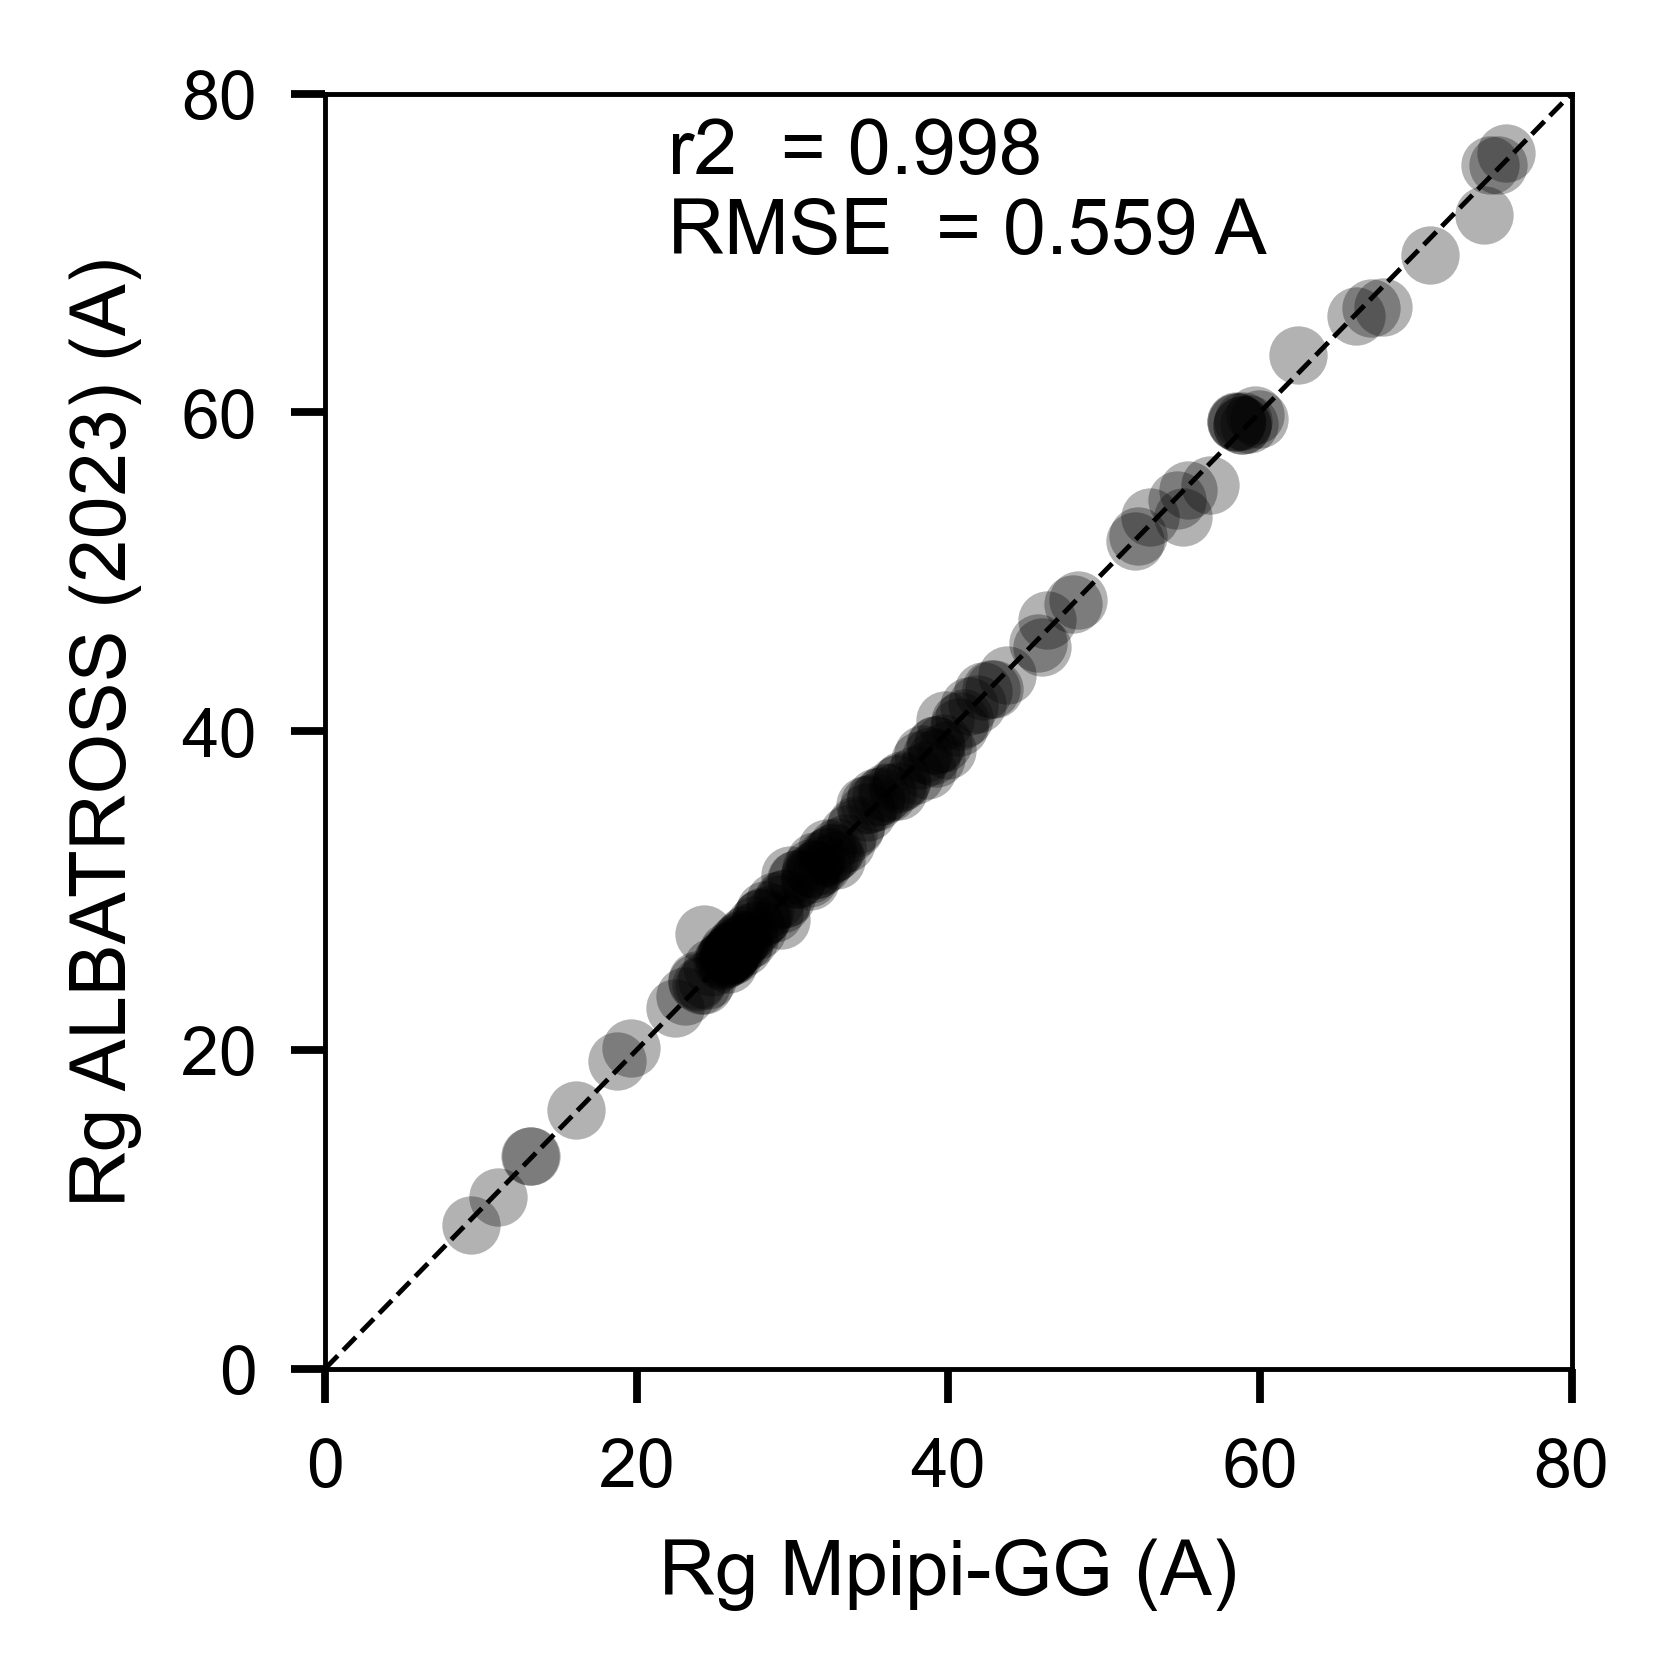

In [30]:
figure(None, (2.5,2.5), dpi=350)

d1 = LAMMPS_rg

d2 = np.array(rg_prediction['ALBATROSS']) 


plt.plot(d1, d2, '.', color='black', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg Mpipi-GG (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])



plt.tight_layout()
plt.savefig('MpipiGG_vs_ALBATROSS.pdf')


## ALBATROSS vs. CALVADOS2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


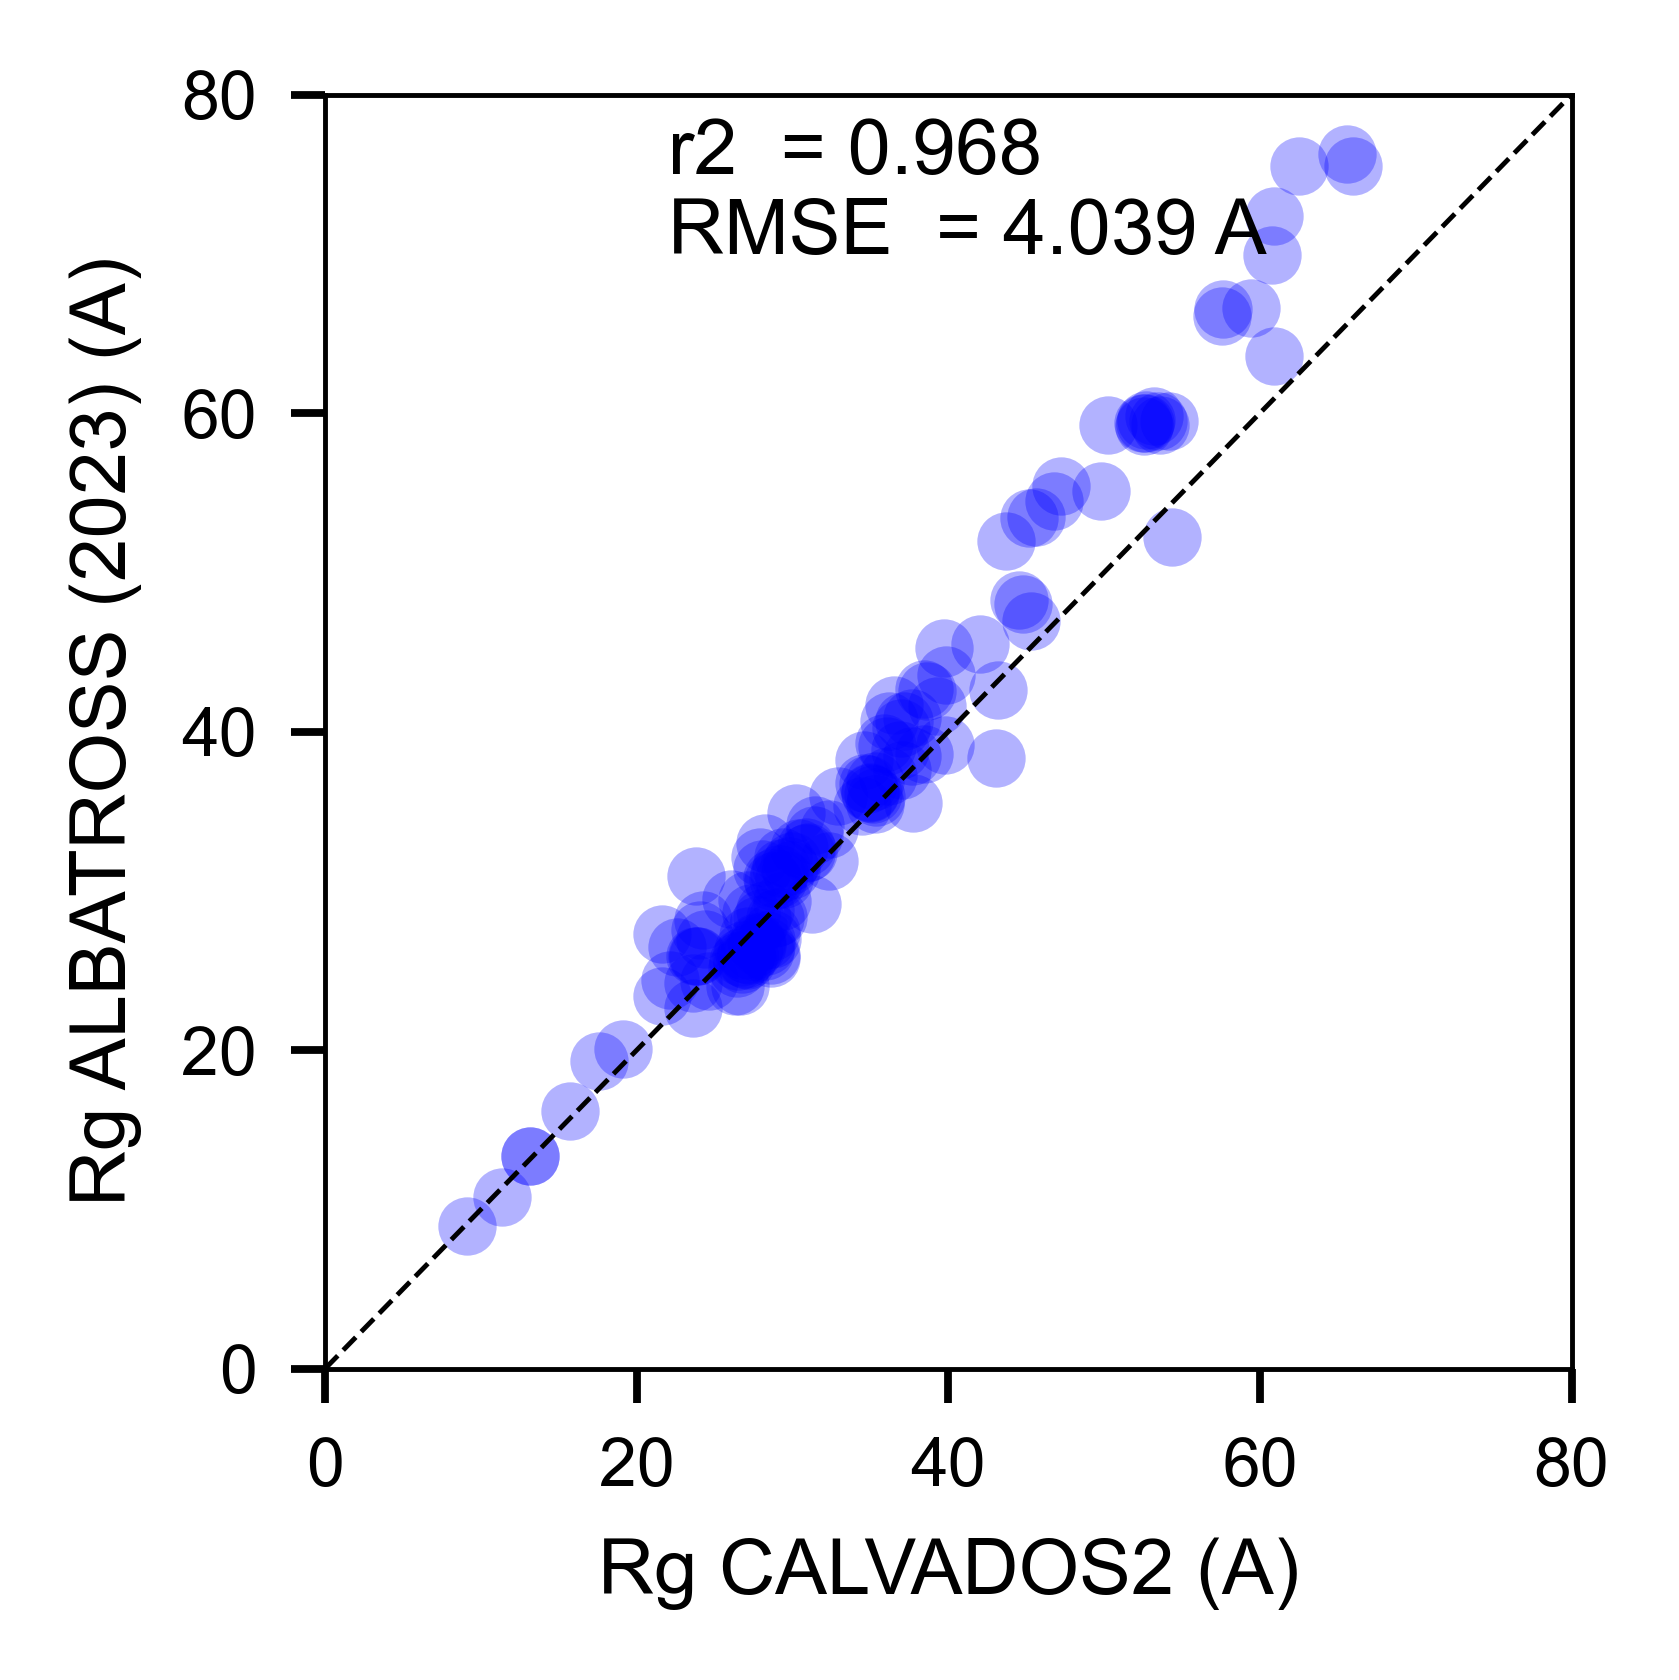

In [35]:
figure(None, (2.5,2.5), dpi=350)


d1 = np.array(rg_prediction['CALVADOS2'])
d2 = np.array(rg_prediction['ALBATROSS']) 





#plt.plot(d1, d2, '.', color='blue', ms=4, mew=0, alpha=0.8, mec='k',label='Mpipi-GG')


plt.plot(d1, d2, '.', color='blue', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg CALVADOS2 (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])




plt.tight_layout()
plt.savefig('CALVADOS2_vs_ALBATROSS.pdf')


### Figure 1B
The code below generates the SAXS vs. ALBATROSS panel shown in Figure 1B

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


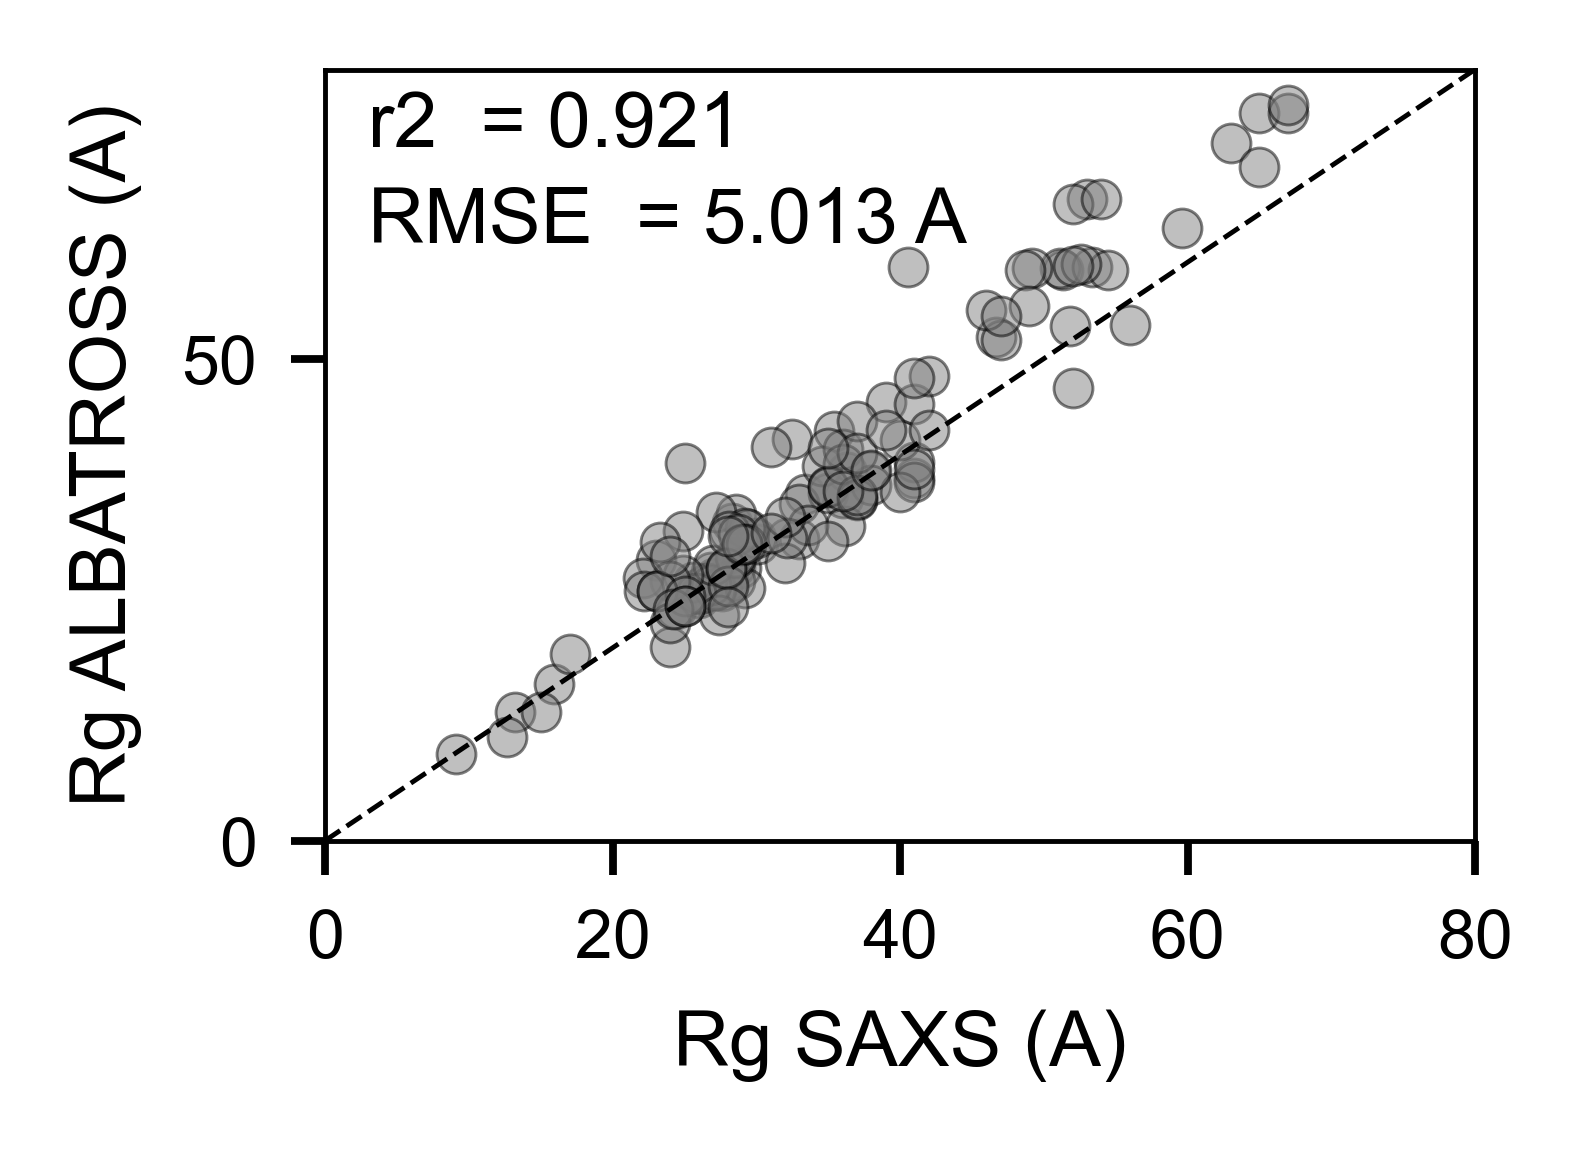

In [33]:
figure(None, (2.36, 1.78), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = np.array(rg_prediction['ALBATROSS'])

plt.plot(d1, d2, '.', color='grey', ms=8, mew=0.3, alpha=0.5, mec='k')

plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(3, 72, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(3, 62, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])




plt.tight_layout()
plt.savefig('FIGURE_1_rg_SAXS_ALBATROSS2.pdf')
